In [1]:

# For data loading
import anndata as ad
import scanpy as sc
import pytorch_lightning as pl
import torch

from wcd_vae.data import get_dataloader_from_adata
from wcd_vae.model import VAE, VAEConfig
from wcd_vae.metrics import compute_metrics

In [2]:
# download all the data
# from ladder.data import get_data
# get_data("Vu")
# get_data("Ji")
# get_data("Mascharak")

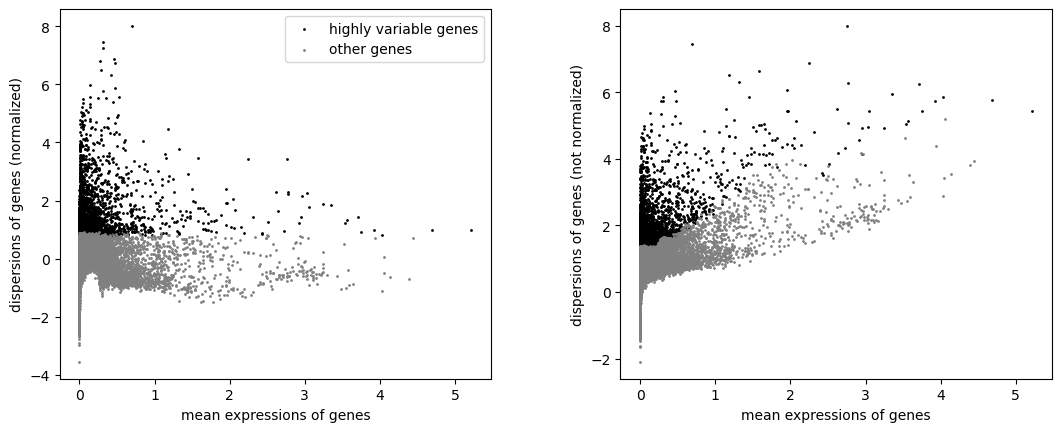

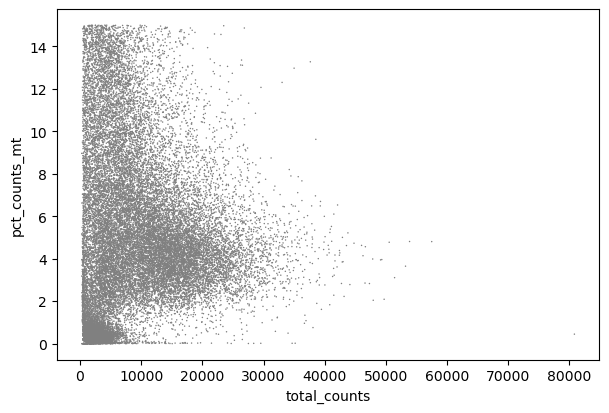

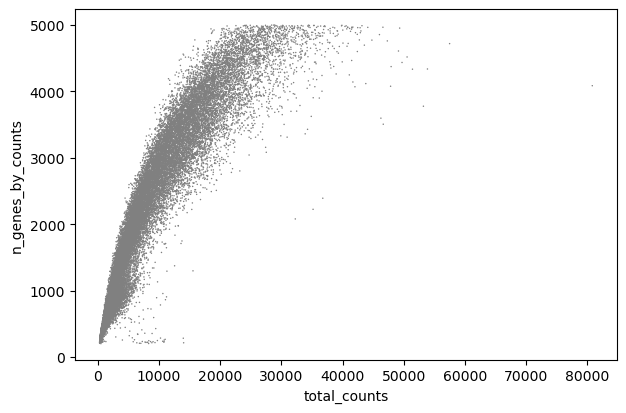

In [3]:
import scanpy as sc
import anndata as ad

# Load the data
anndata = ad.read_h5ad("data/vu_2022_ay_wh.h5ad")

# Save raw counts (if not saved yet)
if "counts" not in anndata.layers:
    anndata.layers["counts"] = anndata.X.copy()

# # Normalize total counts per cell
# sc.pp.normalize_total(anndata, target_sum=1e4)

# # Log-transform
# sc.pp.log1p(anndata)

# Find HVGs
sc.pp.highly_variable_genes(anndata, n_top_genes=3000, batch_key="sample")
sc.pl.highly_variable_genes(anndata)

# QC plots (optional)
sc.pl.scatter(anndata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(anndata, x="total_counts", y="n_genes_by_counts")

# Subset to HVGs, keep normalized + log data
anndata = anndata[:, anndata.var["highly_variable"]].copy()


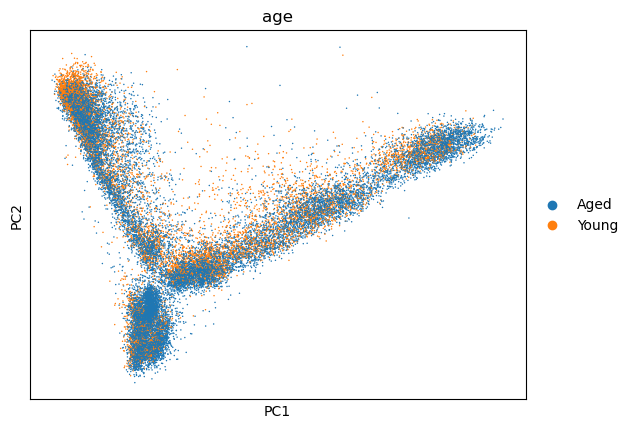

In [4]:
sc.pl.pca(anndata, color="age")

In [5]:
print(anndata.obs['age'].value_counts(normalize=True))

age
Aged     0.632129
Young    0.367871
Name: proportion, dtype: float64


In [6]:
print(anndata.obs['age'].value_counts(normalize=False))

age
Aged     17046
Young     9920
Name: count, dtype: int64


In [7]:
train_loader, test_loader, domain_encoder, cell_encoder = get_dataloader_from_adata(anndata, by = 'age')

In [8]:
config = VAEConfig(
    input_dim=anndata.shape[1],
    latent_dim=100,
    encoder_hidden_dims=[512, 256],
    decoder_hidden_dims=[512, 256],
    dropout=0.1,
    batchsize=128,
    num_epochs=1000,
    lr=1e-3,
    weight_decay=1e-5,
)
vae = VAE(config)

In [9]:
trainer = pl.Trainer(
        max_epochs=config.num_epochs,
        accelerator="auto",  # use 'gpu' or 'cpu' explicitly if needed
        devices="auto",      # or use devices=1
        log_every_n_steps=10,
    )

trainer.fit(vae, train_dataloaders=train_loader, val_dataloaders=test_loader)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/envs/myenv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trad


  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | encoder | Encoder | 1.7 M  | train
1 | decoder | Decoder | 954 K  | train
--------------------------------------------
2.7 M     Trainable params
0         Non-trainable params
2.7 M     Total params
10.693    Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 

Epoch 0:   3%|▎         | 5/169 [00:00<00:02, 78.21it/s, v_num=24, train_loss=5.450, recon_loss=0.273, kl_div=5.180]

RuntimeError: DataLoader worker (pid(s) 32329) exited unexpectedly

In [ ]:
from tqdm import tqdm  # import tqdm

embeddings = []
batches = []
cell_type = []

vae.eval()
vae  = vae.to("cuda" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating VAE"):
        x, batch_label, cell_label = batch
        x, batch_label, cell_label = x.to(vae.device), batch_label.to(vae.device), cell_label.to(vae.device)
        recon_batch, embed, mu, logvar = vae(x)
        embeddings.append(embed.cpu())
        batches.append(batch_label.cpu())
        cell_type.append(cell_label.cpu())

# Concatenate the results
embeddings = torch.cat(embeddings, dim=0)
batches = torch.cat(batches, dim=0)
cell_type = torch.cat(cell_type, dim=0)


Evaluating VAE: 100%|██████████| 43/43 [00:00<00:00, 162.62it/s]


In [ ]:
compute_metrics(
    embeddings=embeddings,
    batch_labels=batches,
    cell_type_labels=cell_type,
)

{'batch_entropy': 0.6931471824645996,
 'ilisi_batch': 2.0,
 'clisi_celltype': 1.2195122241973877,
 'silhouette_score': -0.027044039219617844,
 'normalized_mutual_info': 0.00041299566030934126}

In [ ]:
batches.shape

torch.Size([5394, 2])

/opt/conda/envs/myenv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/envs/myenv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


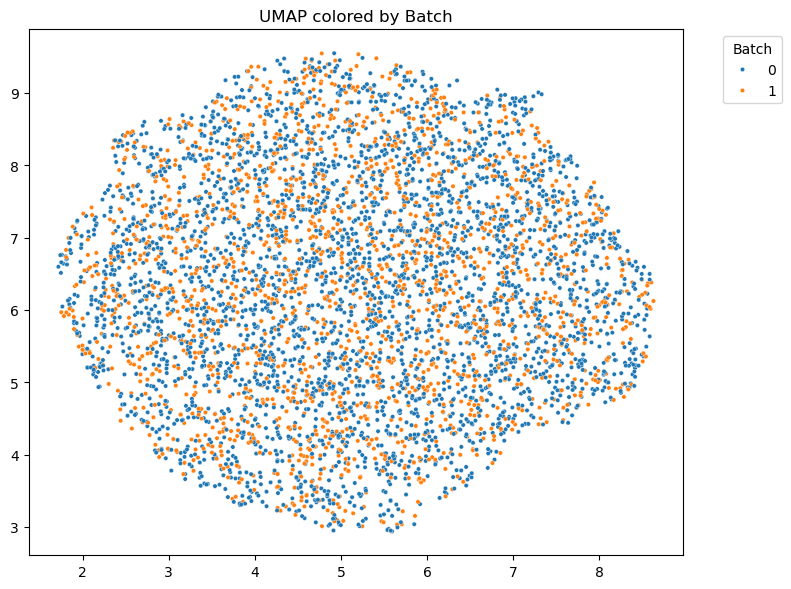

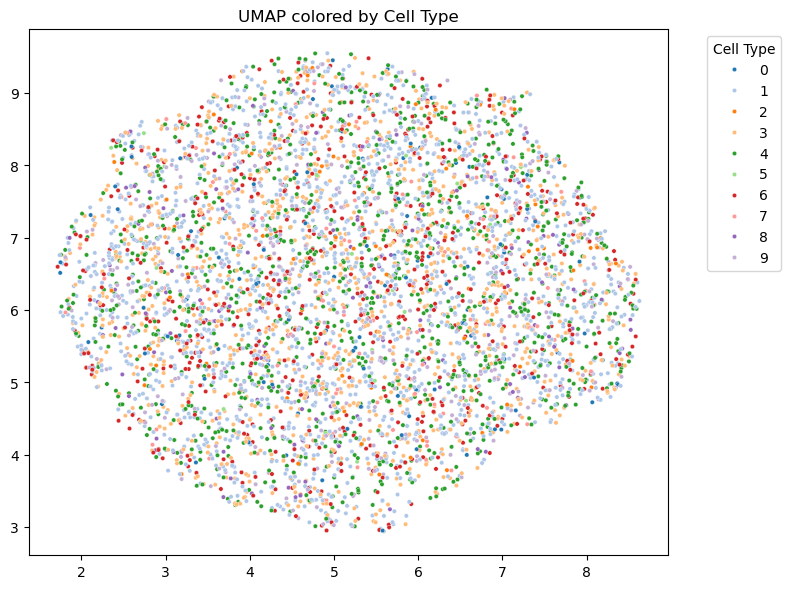

In [ ]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Ensure embeddings, batches, and cell_type are on CPU and numpy
embeddings_np = embeddings.numpy()
batches_np = batches.argmax(dim=1).numpy()
cell_type_np = cell_type.argmax(dim=1).numpy()

# Fit UMAP on embeddings
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embedding_2d = umap_model.fit_transform(embeddings_np)

# Plot by batch
plt.figure(figsize=(8, 6))
sns.scatterplot(x=embedding_2d[:, 0], y=embedding_2d[:, 1], hue=batches_np, palette="tab10", s=10)
plt.title("UMAP colored by Batch")
plt.legend(title="Batch", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Plot by cell type
plt.figure(figsize=(8, 6))
sns.scatterplot(x=embedding_2d[:, 0], y=embedding_2d[:, 1], hue=cell_type_np, palette="tab20", s=10)
plt.title("UMAP colored by Cell Type")
plt.legend(title="Cell Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()
